In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, 
                             SpectralClustering, MeanShift, AffinityPropagation,
                             MiniBatchKMeans, Birch, BisectingKMeans, OPTICS)
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import entropy, kruskal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, homogeneity_completeness_v_measure

In [2]:
X = pd.read_csv('data/processed/X_scaled.csv')
y = pd.read_csv('data/processed/y.csv')

## Training Clustering
- K-Means
- Spectral clustering: Dado a que el hiperparametro n_cluster=3 solo da un label, se probo reduciendo gamma de 1.0 a 0.1, pero obtuvo (array([0, 1, 2], dtype=int32), array([1092,    1,    1])),

se probo tambien affinity='nearest_neighbors' y ahi dio mejores resultados (array([0, 1, 2], dtype=int32), array([473, 322, 299]))

In [12]:
class Clustering():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.clusters = {}
        self.scores = {}
        self.models = {
            # Densidad
            'DBSCAN': DBSCAN(eps=2, min_samples=2),
            'OPTICS': OPTICS(min_samples=3),
            'MeanShift': MeanShift(bandwidth=3, cluster_all=True),
            # Modelos
            'AffinityPropagation': AffinityPropagation(random_state=42),
        }
        for k in range(2, 10):
            # Particiones
            self.models[f'KMeans_{k}'] = KMeans(n_clusters=k, random_state=42)
            self.models[f'SpectralClustering_{k}'] = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
            # Jerárquico
            self.models[f'AgglomerativeClustering_{k}'] = AgglomerativeClustering(n_clusters=k)
            self.models[f'Birch_{k}'] = Birch(n_clusters=k)

    def apply_pca(self, n_components=2):
        pca = PCA(n_components=n_components)
        self.X_pca = pca.fit_transform(self.X)

        
    def fit(self):
        for name, model in self.models.items():
            print(f'Fitting {name}')
            model.fit(self.X)
            if hasattr(model, 'predict'):
                self.clusters[name] = model.predict(self.X)
                labels = model.labels_
            else:
                self.clusters[name] = model.labels_
                labels = model.labels_
            valid_mask = labels != -1
            X_valid = self.X[valid_mask]
            valid_labels = labels[valid_mask]

            self.scores[name] = {}
            if len(set(valid_labels)) > 1:
                label_counts = np.bincount(valid_labels)
                self.scores[name]['siluetas'] = silhouette_score(X=X_valid, labels=valid_labels)
                self.scores[name]['calinski'] = calinski_harabasz_score(X=X_valid, labels=valid_labels)
                self.scores[name]['davies'] = davies_bouldin_score(X=X_valid, labels=valid_labels)
                self.scores[name]['entropia'] = entropy(label_counts / len(valid_labels), base=2)
            else:
                self.scores[name]['siluetas'] = None
                self.scores[name]['calinski'] = None
                self.scores[name]['davies'] = None
                self.scores[name]['entropia'] = 0  # No hay entropía si solo hay un cluster
    
    def plot(self):
        for name, model in self.models.items():
            clusters = self.clusters[name]
            unique_clusters = np.unique(clusters)

            for cluster in unique_clusters:
                mask = clusters == cluster
                plt.scatter(self.X_pca[mask, 0], self.X_pca[mask, 1], 
                            label=f'Cluster {cluster}' if cluster != -1 else 'Noise',
                            alpha=0.7)
            plt.title(name)
            plt.legend(title="Clusters")
            plt.savefig(f'img/clustering-scatterplot-{name}.png')
            plt.show()
    
    def get_scores(self):
        data = []
        for name, model in self.models.items():
            noise = np.sum(self.clusters[name] == -1)
            data.append([name, self.scores[name]['siluetas'], self.scores[name]['calinski'], self.scores[name]['davies'], self.scores[name]['entropia'], noise])
        return pd.DataFrame(data, columns=['Modelo', 'Siluetas', 'Calinski', 'Davies', 'Entropia', 'Ruido'])
        
    def predict(self, X):
        for name, model in self.models.items():
            self.clusters[name] = model.predict(X)
        return self.clusters
    
    def statistics(self):
        self.statistics = {}
        for name, model in self.models.items():
            self.statistics[name] = {}
            print(f'Estadísticas para {name}')
            self.statistics[name]["n_clusters"] = len(set(model.labels_))
            self.statistics[name]["cluster_sizes"] = pd.Series(model.labels_).value_counts().to_frame().reset_index().rename(columns={'index': 'Cluster', 'count': 'Size'})
            data = pd.concat([self.X, pd.Series(model.labels_, name='Cluster')], axis=1)
            descriptive_stats = data.groupby('Cluster').describe()
            self.statistics[name]["descriptive_stats"] = descriptive_stats
            krskl = []
            clusters = self.statistics[name]["cluster_sizes"]["Cluster"].values
            for column in self.X.columns:
                groups = [data.loc[data["Cluster"] == cluster, column].values for cluster in clusters]
                krskl.append([column, *kruskal(*groups)])
                del groups
            self.statistics[name]["kruskal"] = pd.DataFrame(krskl, columns=["Column", "H", "p-value"])

In [13]:
clustering_instance = Clustering(X, y)
clustering_instance.fit()

Fitting DBSCAN
Fitting OPTICS
Fitting MeanShift
Fitting AffinityPropagation
Fitting KMeans_2
Fitting SpectralClustering_2
Fitting AgglomerativeClustering_2
Fitting Birch_2
Fitting KMeans_3
Fitting SpectralClustering_3
Fitting AgglomerativeClustering_3
Fitting Birch_3
Fitting KMeans_4
Fitting SpectralClustering_4
Fitting AgglomerativeClustering_4
Fitting Birch_4
Fitting KMeans_5
Fitting SpectralClustering_5
Fitting AgglomerativeClustering_5
Fitting Birch_5
Fitting KMeans_6
Fitting SpectralClustering_6
Fitting AgglomerativeClustering_6
Fitting Birch_6
Fitting KMeans_7
Fitting SpectralClustering_7
Fitting AgglomerativeClustering_7
Fitting Birch_7
Fitting KMeans_8
Fitting SpectralClustering_8
Fitting AgglomerativeClustering_8
Fitting Birch_8
Fitting KMeans_9
Fitting SpectralClustering_9
Fitting AgglomerativeClustering_9
Fitting Birch_9


### Bug conocido
A veces, si se ejecuta por segunda vez, aparece el error:

TypeError: 'DataFrame' object is not callable

No sé por qué ocurre pero con reiniciar el Kernel vuelve a funcionar

In [5]:
clustering_instance.statistics()

Estadísticas para DBSCAN
Estadísticas para OPTICS
Estadísticas para MeanShift
Estadísticas para AffinityPropagation
Estadísticas para KMeans_2
Estadísticas para SpectralClustering_2
Estadísticas para AgglomerativeClustering_2
Estadísticas para Birch_2
Estadísticas para KMeans_3
Estadísticas para SpectralClustering_3
Estadísticas para AgglomerativeClustering_3
Estadísticas para Birch_3
Estadísticas para KMeans_4
Estadísticas para SpectralClustering_4
Estadísticas para AgglomerativeClustering_4
Estadísticas para Birch_4
Estadísticas para KMeans_5
Estadísticas para SpectralClustering_5
Estadísticas para AgglomerativeClustering_5
Estadísticas para Birch_5
Estadísticas para KMeans_6
Estadísticas para SpectralClustering_6
Estadísticas para AgglomerativeClustering_6
Estadísticas para Birch_6
Estadísticas para KMeans_7
Estadísticas para SpectralClustering_7
Estadísticas para AgglomerativeClustering_7
Estadísticas para Birch_7
Estadísticas para KMeans_8
Estadísticas para SpectralClustering_8
Es

In [6]:
clustersize_df = pd.DataFrame()
descriptive_stats_df = pd.DataFrame()
kruskal_df = pd.DataFrame()

for name in clustering_instance.models.keys():
    print(f"Algorithm: {name}\tN_clusters: {clustering_instance.statistics[name]["n_clusters"]}")
    
    clustersize = clustering_instance.statistics[name]["cluster_sizes"]
    clustersize["Model"] = name
    clustersize_df = pd.concat([clustersize_df, clustersize])

    descriptive_stats = clustering_instance.statistics[name]["descriptive_stats"]
    descriptive_stats["Model"] = name
    descriptive_stats_df = pd.concat([descriptive_stats_df, descriptive_stats])

    kruskal = clustering_instance.statistics[name]["kruskal"]
    kruskal["Model"] = name
    kruskal_df = pd.concat([kruskal_df, kruskal])

Algorithm: DBSCAN	N_clusters: 11
Algorithm: OPTICS	N_clusters: 11
Algorithm: MeanShift	N_clusters: 89
Algorithm: AffinityPropagation	N_clusters: 108
Algorithm: KMeans_2	N_clusters: 2
Algorithm: SpectralClustering_2	N_clusters: 2
Algorithm: AgglomerativeClustering_2	N_clusters: 2
Algorithm: Birch_2	N_clusters: 2
Algorithm: KMeans_3	N_clusters: 3
Algorithm: SpectralClustering_3	N_clusters: 3
Algorithm: AgglomerativeClustering_3	N_clusters: 3
Algorithm: Birch_3	N_clusters: 3
Algorithm: KMeans_4	N_clusters: 4
Algorithm: SpectralClustering_4	N_clusters: 4
Algorithm: AgglomerativeClustering_4	N_clusters: 4
Algorithm: Birch_4	N_clusters: 4
Algorithm: KMeans_5	N_clusters: 5
Algorithm: SpectralClustering_5	N_clusters: 5
Algorithm: AgglomerativeClustering_5	N_clusters: 5
Algorithm: Birch_5	N_clusters: 5
Algorithm: KMeans_6	N_clusters: 6
Algorithm: SpectralClustering_6	N_clusters: 6
Algorithm: AgglomerativeClustering_6	N_clusters: 6
Algorithm: Birch_6	N_clusters: 6
Algorithm: KMeans_7	N_clusters:

In [7]:
clustersize_df

Cluster  Size    Model
0        -1  1499   DBSCAN
1         6     3   DBSCAN
2         0     2   DBSCAN
3         1     2   DBSCAN
4         2     2   DBSCAN
..      ...   ...      ...
4         5   162  Birch_9
5         3   146  Birch_9
6         7   140  Birch_9
7         6   140  Birch_9
8         8    87  Birch_9

[395 rows x 3 columns]

In [8]:
descriptive_stats_df

Age                                                           \
          count      mean       std     min       25%      50%       75%   
Cluster                                                                    
-1       1499.0 -0.011883  0.561880 -0.9375 -0.500000  0.00000  0.500000   
 0          2.0 -0.125000  0.000000 -0.1250 -0.125000 -0.12500 -0.125000   
 1          2.0 -0.625000  0.353553 -0.8750 -0.750000 -0.62500 -0.500000   
 2          2.0 -0.562500  0.088388 -0.6250 -0.593750 -0.56250 -0.531250   
 3          2.0  0.406250  0.220971  0.2500  0.328125  0.40625  0.484375   
...         ...       ...       ...     ...       ...      ...       ...   
 4        211.0  0.178021  0.543549 -0.9375 -0.250000  0.31250  0.625000   
 5        162.0  0.047840  0.559735 -0.9375 -0.375000  0.06250  0.562500   
 6        140.0 -0.060268  0.537301 -0.9375 -0.562500 -0.12500  0.390625   
 7        140.0  0.126339  0.566580 -0.9375 -0.375000  0.25000  0.625000   
 8         87.0 -0.013649  0.546978 -0.8750 -0.468750 -0.12500  0.468750   

                 Gender            ... EducationLevel_2 EducationLevel_3  \
            max   count      mean  ...              max            count   
Cluster                            ...                                     
-1       0.9375  1499.0  0.495664  ...              1.0           1499.0   
 0      -0.1250     2.0  0.000000  ...              1.0              2.0   
 1      -0.3750     2.0  1.000000  ...              0.0              2.0   
 2      -0.5000     2.0  1.000000  ...              1.0              2.0   
 3       0.5625     2.0  1.000000  ...              0.0              2.0   
...         ...     ...       ...  ...              ...              ...   
 4       0.9375   211.0  0.497630  ...              1.0            211.0   
 5       0.9375   162.0  0.487654  ...              0.0            162.0   
 6       0.9375   140.0  0.564286  ...              1.0            140.0   
 7       0.9375   140.0  0.628571  ...              1.0            140.0   
 8       0.9375    87.0  0.448276  ...              1.0             87.0   

                                                        Model  
             mean       std  min  25%  50%  75%  max           
Cluster                                                        
-1       0.098065  0.297502  0.0  0.0  0.0  0.0  1.0   DBSCAN  
 0       0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   DBSCAN  
 1       0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   DBSCAN  
 2       0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   DBSCAN  
 3       0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   DBSCAN  
...           ...       ...  ...  ...  ...  ...  ...      ...  
 4       0.052133  0.222823  0.0  0.0  0.0  0.0  1.0  Birch_9  
 5       0.024691  0.155664  0.0  0.0  0.0  0.0  1.0  Birch_9  
 6       0.035714  0.186243  0.0  0.0  0.0  0.0  1.0  Birch_9  
 7       0.092857  0.291274  0.0  0.0  0.0  0.0  1.0  Birch_9  
 8       0.149425  0.358574  0.0  0.0  0.0  0.0  1.0  Birch_9  

[395 rows x 305 columns]

In [9]:
kruskal_df

Column           H       p-value    Model
0                  Age   17.271061  6.857716e-02   DBSCAN
1               Gender   21.075512  2.057313e-02   DBSCAN
2                  BMI   11.136538  3.469799e-01   DBSCAN
3              Smoking   16.680310  8.174405e-02   DBSCAN
4   AlcoholConsumption   14.243404  1.621759e-01   DBSCAN
..                 ...         ...           ...      ...
33         Ethnicity_3   49.748167  4.568337e-08  Birch_9
34    EducationLevel_0  361.658860  2.935332e-73  Birch_9
35    EducationLevel_1  472.833307  4.720168e-97  Birch_9
36    EducationLevel_2  464.832740  2.449738e-95  Birch_9
37    EducationLevel_3   52.947573  1.103950e-08  Birch_9

[1368 rows x 4 columns]

In [14]:
clustering_instance.apply_pca()

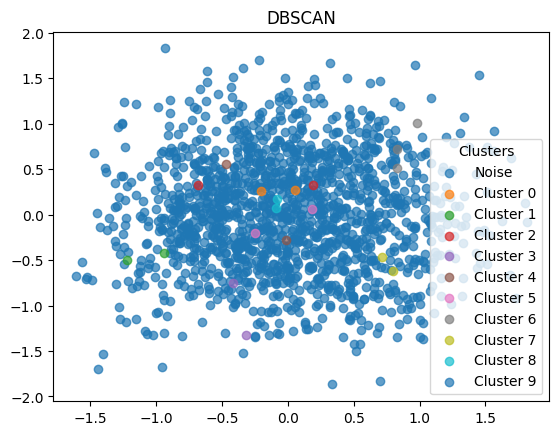

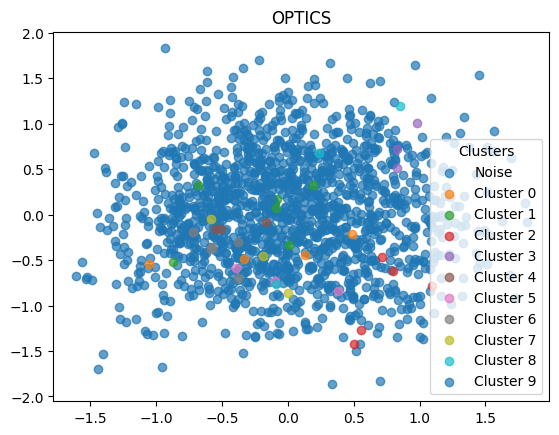

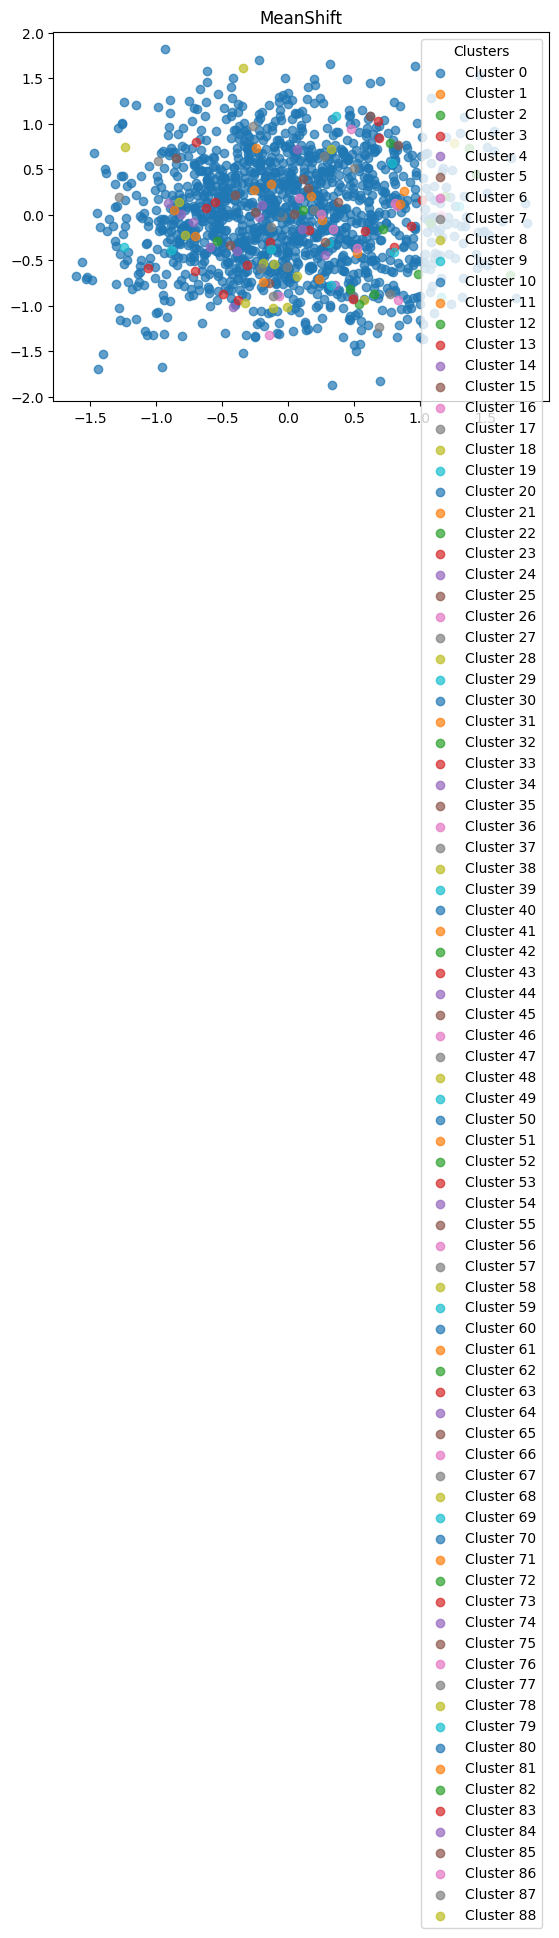

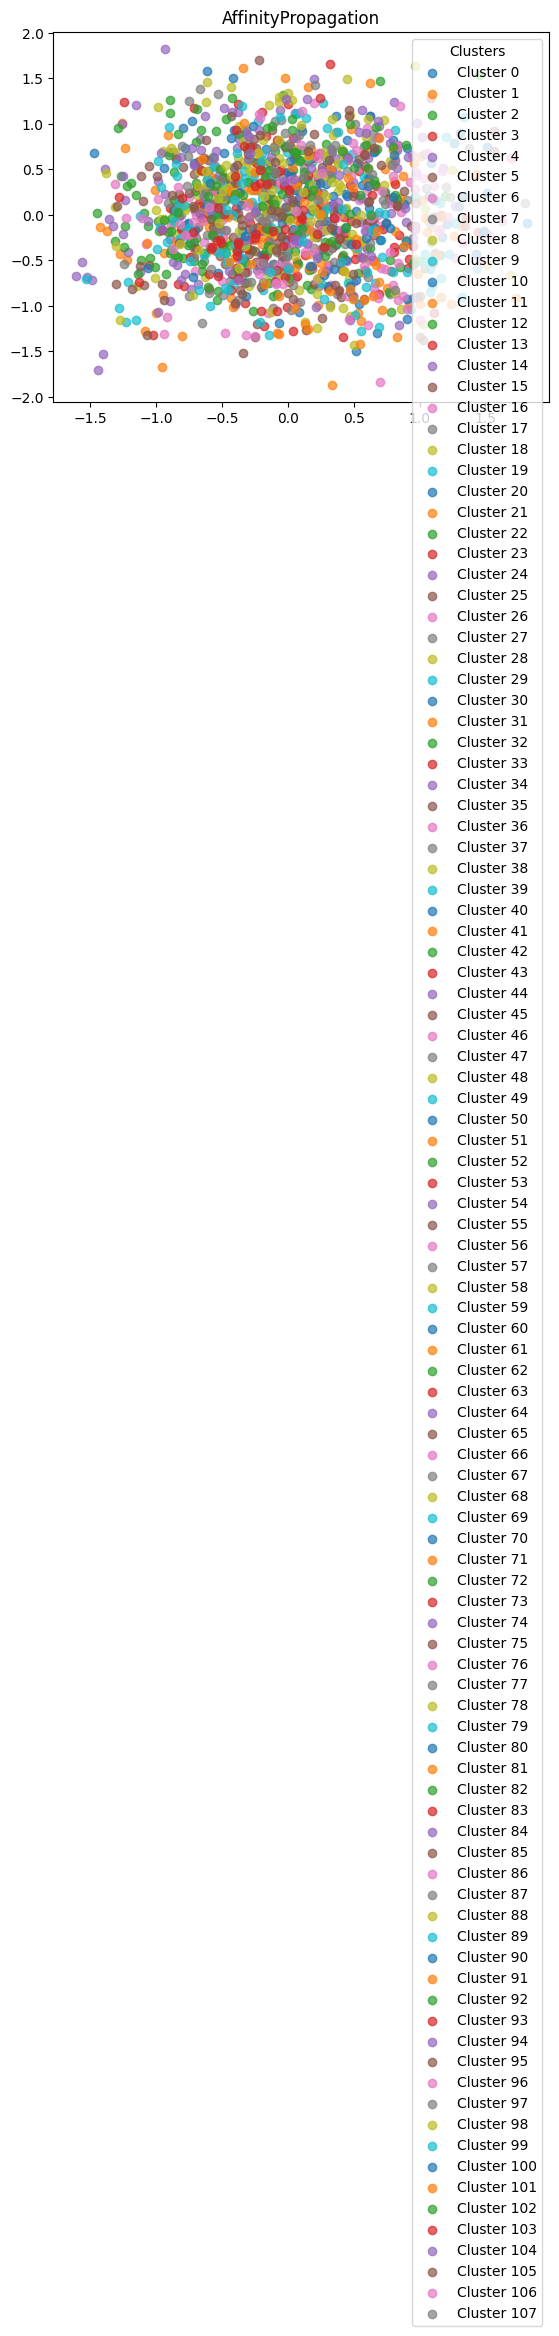

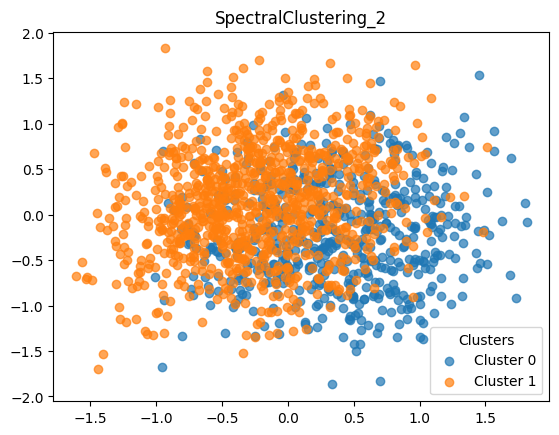

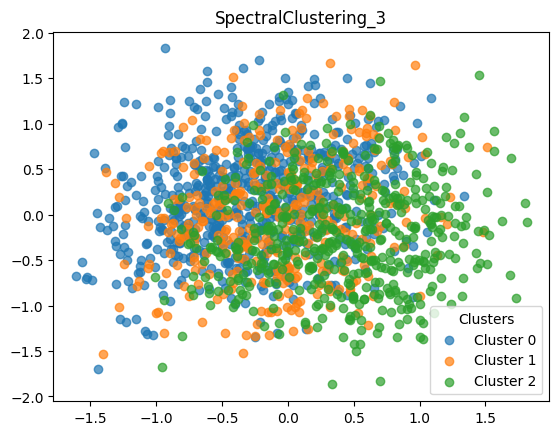

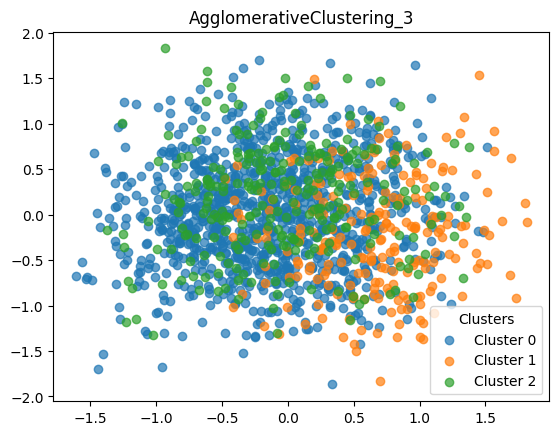

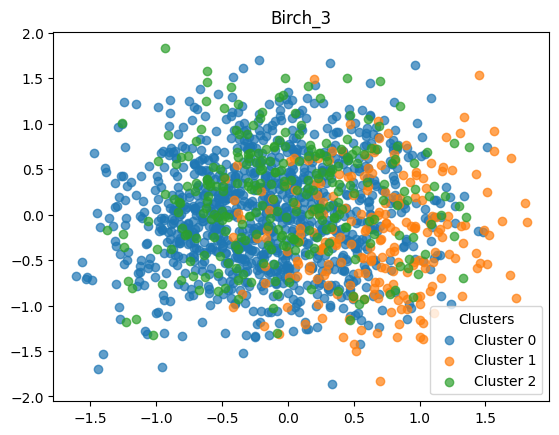

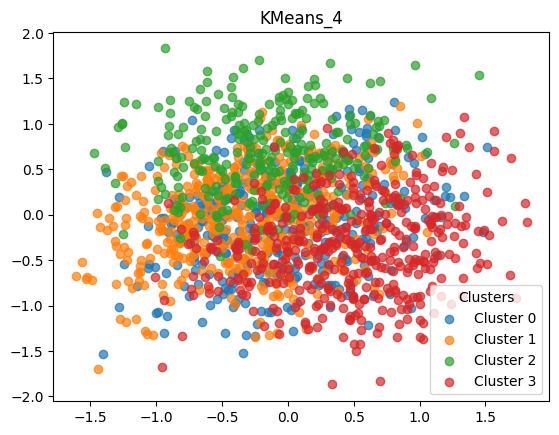

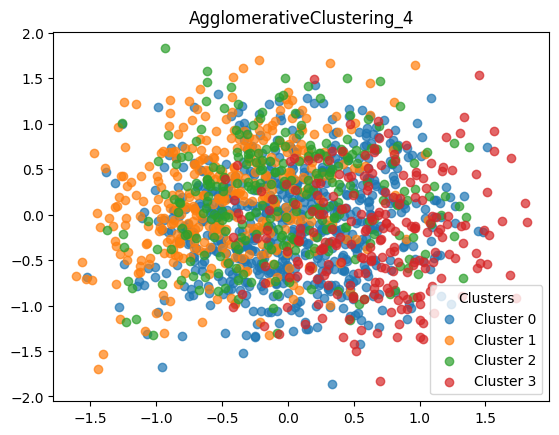

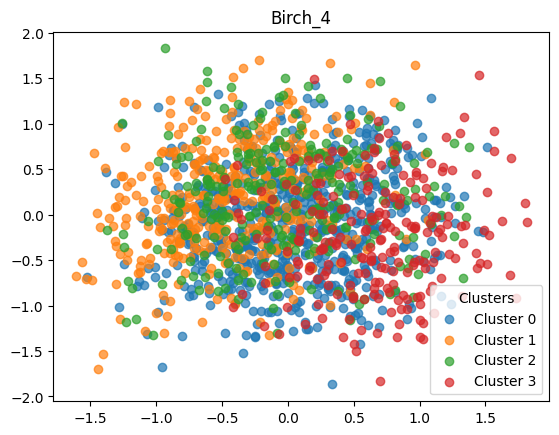

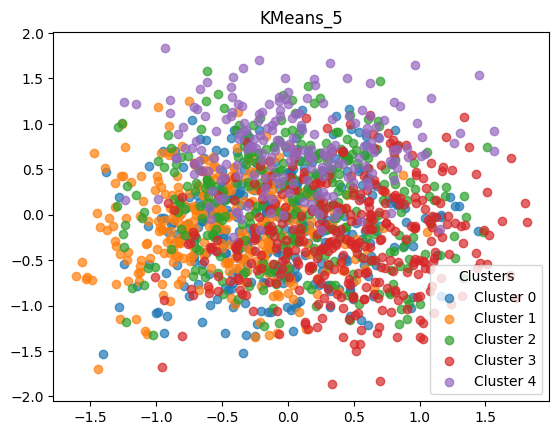

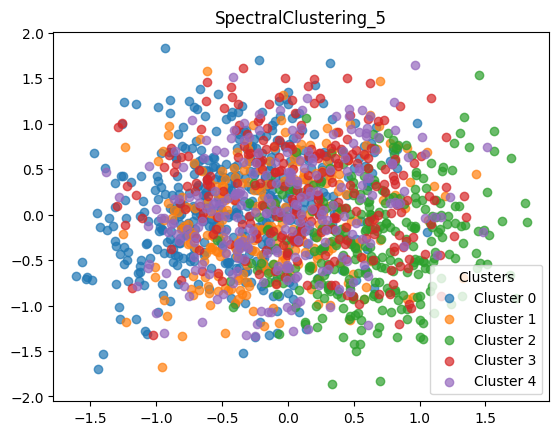

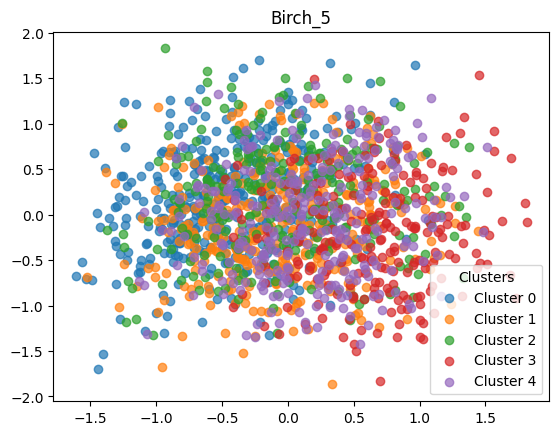

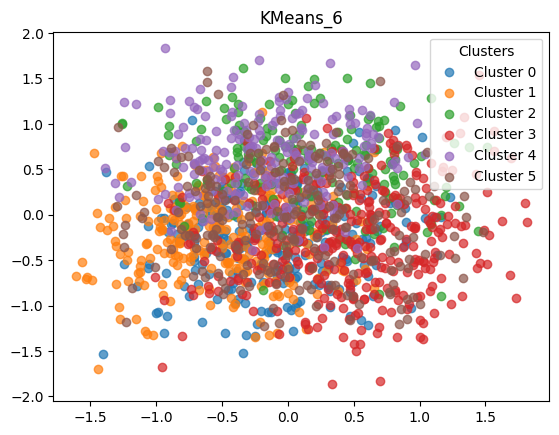

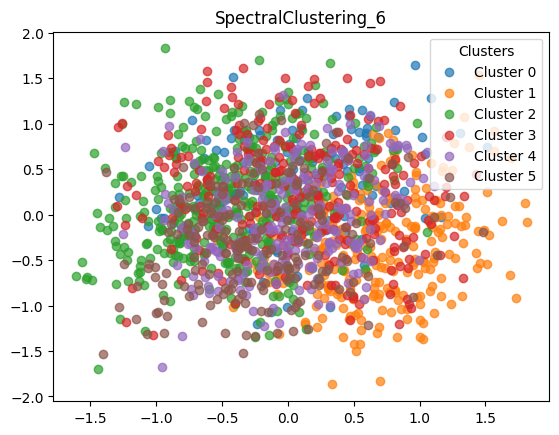

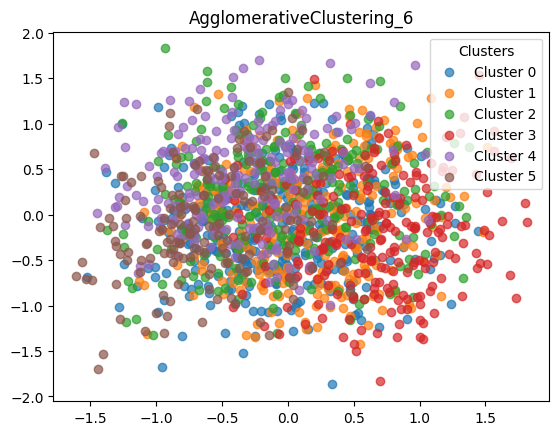

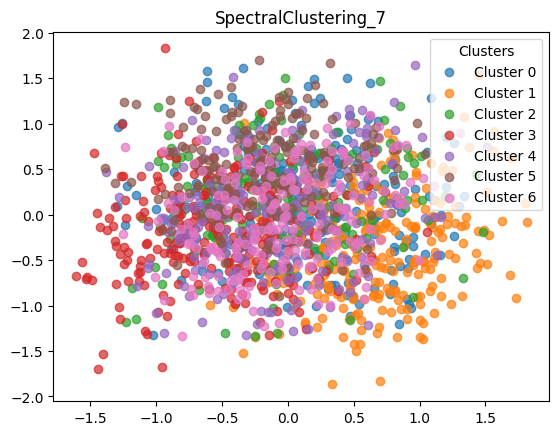

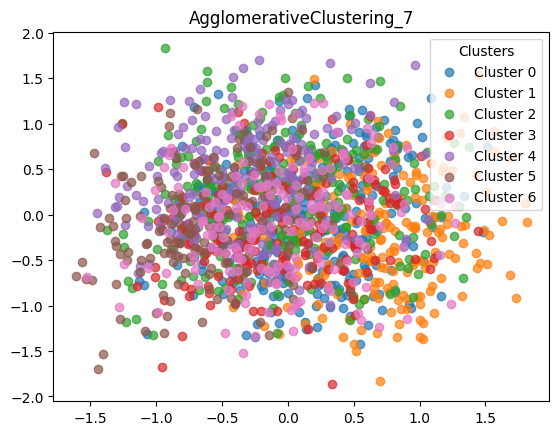

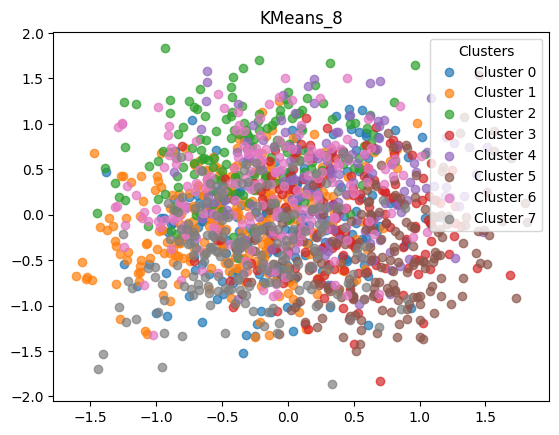

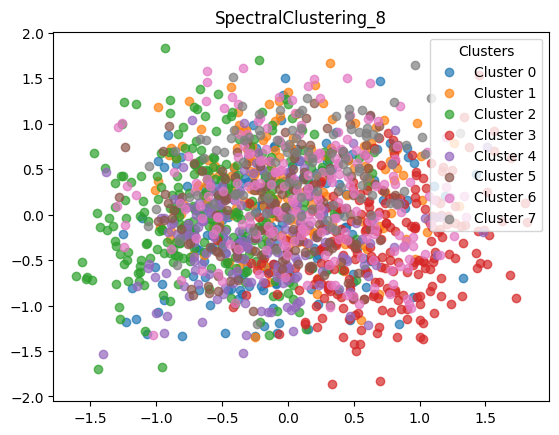

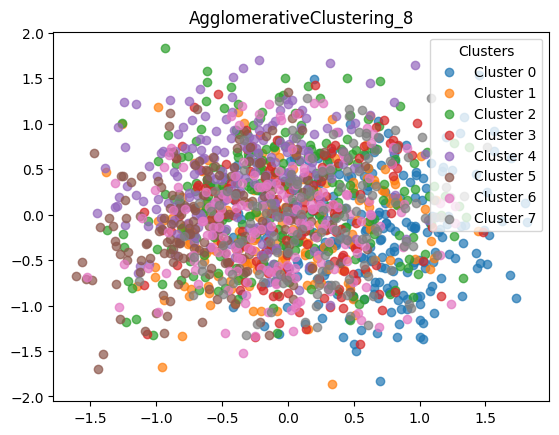

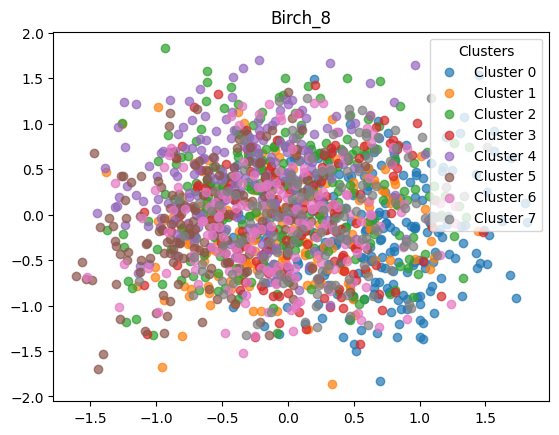

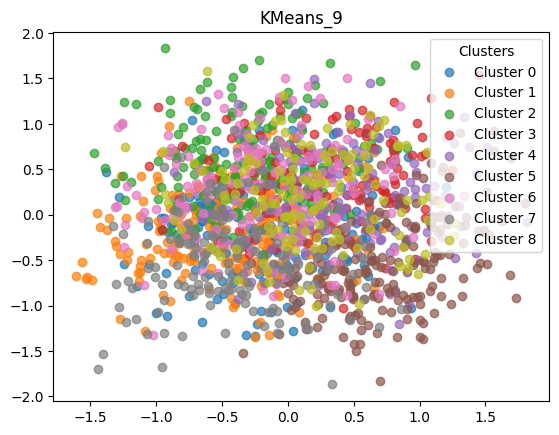

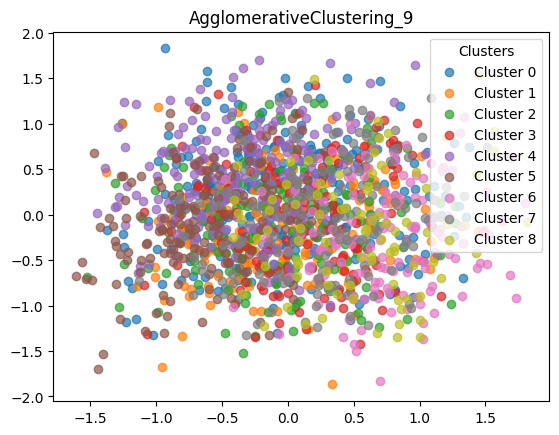

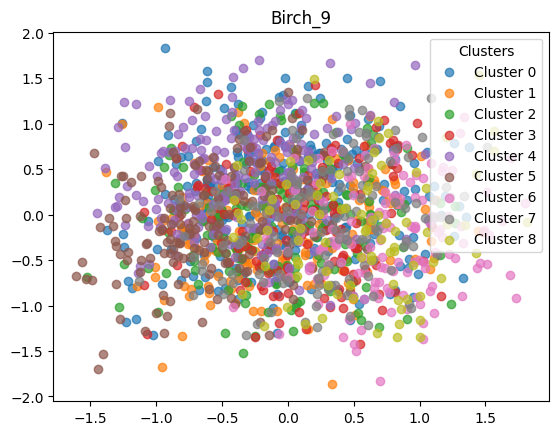

In [15]:
clustering_instance.plot()

https://stats.stackexchange.com/questions/338719/calculating-clusters-entropy-python

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

In [17]:
clustering_instance.get_scores().sort_values(by=['Ruido','Siluetas', 'Calinski', 'Davies', 'Entropia'], ascending=[True, False, False, True, True])

Modelo  Siluetas   Calinski    Davies  Entropia  Ruido
4                    KMeans_2  0.037755  62.263234  4.787324  0.967788      0
12                   KMeans_4  0.036859  43.140534  4.364385  1.975446      0
13       SpectralClustering_4  0.033915  41.262395  4.348943  1.978564      0
9        SpectralClustering_3  0.032508  42.379822  5.013578  1.544242      0
16                   KMeans_5  0.032188  39.877365  4.293750  2.295797      0
17       SpectralClustering_5  0.032025  35.330396  4.507904  2.288426      0
5        SpectralClustering_2  0.031970  48.047294  5.430365  0.958690      0
20                   KMeans_6  0.030889  35.257722  4.140598  2.549564      0
28                   KMeans_8  0.029990  29.993316  4.087852  2.978760      0
24                   KMeans_7  0.029809  33.428818  4.068720  2.783720      0
32                   KMeans_9  0.028427  27.776712  3.778493  3.155052      0
8                    KMeans_3  0.028118  48.663433  4.683256  1.572757      0
21       SpectralClustering_6  0.026843  30.848188  4.549539  2.513519      0
25       SpectralClustering_7  0.023210  28.416136  4.554316  2.797403      0
29       SpectralClustering_8  0.022277  25.797865  4.516814  2.947146      0
33       SpectralClustering_9  0.020238  23.870464  4.235839  3.147549      0
3         AffinityPropagation  0.015889   6.366350  2.698956  6.654541      0
6   AgglomerativeClustering_2  0.015845  24.864818  5.453927  0.608191      0
7                     Birch_2  0.015845  24.864818  5.453927  0.608191      0
10  AgglomerativeClustering_3  0.012067  23.694237  5.945315  1.238272      0
11                    Birch_3  0.012067  23.694237  5.945315  1.238272      0
18  AgglomerativeClustering_5  0.007665  20.700516  6.012630  2.297453      0
19                    Birch_5  0.007665  20.700516  6.012630  2.297453      0
14  AgglomerativeClustering_4  0.007364  22.083213  6.492556  1.874825      0
15                    Birch_4  0.007364  22.083213  6.492556  1.874825      0
30  AgglomerativeClustering_8  0.005160  18.219136  4.969256  2.966634      0
31                    Birch_8  0.005160  18.219136  4.969256  2.966634      0
26  AgglomerativeClustering_7  0.004468  18.902061  5.221637  2.778536      0
27                    Birch_7  0.004468  18.902061  5.221637  2.778536      0
34  AgglomerativeClustering_9  0.003787  17.428742  4.831280  3.110049      0
35                    Birch_9  0.003787  17.428742  4.831280  3.110049      0
22  AgglomerativeClustering_6  0.003130  19.806517  5.703640  2.539784      0
23                    Birch_6  0.003130  19.806517  5.703640  2.539784      0
2                   MeanShift -0.136291   1.636131  1.162464  0.961578      0
1                      OPTICS  0.206674   4.973490  1.265327  3.267444   1482
0                      DBSCAN  0.333170   5.924739  0.745035  3.308751   1499

In [18]:
best_nodel = clustering_instance.get_scores().sort_values(by=['Ruido','Siluetas', 'Calinski', 'Davies', 'Entropia'], ascending=[True, False, False, True, True]).iloc[0]['Modelo']
best_nodel

'KMeans_2'

In [27]:
contingency_table = pd.crosstab(clustering_instance.clusters[best_nodel], np.squeeze(y))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Diagnosis")
plt.ylabel("Clusters")
plt.savefig('img/clustering-contingency-kmeans2.png')

In [15]:
#def conditional_entropy(cluster_labels, true_labels):
#    contingency = pd.crosstab(cluster_labels, true_labels).to_numpy()
#    cluster_totals = contingency.sum(axis=1, keepdims=True)
#    probabilities = contingency / cluster_totals
#    entropies = entropy(probabilities, axis=1, base=2)
#    weighted_entropy = (entropies * cluster_totals.flatten()).sum() / cluster_totals.sum()
#    return weighted_entropy

data = []
for name, model in clustering_instance.models.items():
    #ce = conditional_entropy(clustering_instance.clusters[name], np.squeeze(y))
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(np.squeeze(y), clustering_instance.clusters[name])
    data.append([name, homogeneity, completeness, v_measure])

results = pd.DataFrame(data, columns=["Model", "Homogeneity", "Completeness", "V-Measure"])
results.sort_values(by=["Homogeneity"], ascending=False)

    

Model  Homogeneity  Completeness  V-Measure
3         AffinityPropagation     0.177144      0.026620   0.046285
32                   KMeans_9     0.066867      0.021194   0.032186
2                   MeanShift     0.065360      0.067971   0.066640
8                    KMeans_3     0.050703      0.032238   0.039415
28                   KMeans_8     0.047673      0.016004   0.023964
33       SpectralClustering_9     0.045198      0.014360   0.021795
29       SpectralClustering_8     0.041545      0.014097   0.021051
35                    Birch_9     0.039510      0.012704   0.019226
34  AgglomerativeClustering_9     0.039510      0.012704   0.019226
30  AgglomerativeClustering_8     0.039350      0.013264   0.019841
31                    Birch_8     0.039350      0.013264   0.019841
27                    Birch_7     0.038968      0.014025   0.020626
26  AgglomerativeClustering_7     0.038968      0.014025   0.020626
25       SpectralClustering_7     0.038507      0.013765   0.020281
23                    Birch_6     0.038097      0.015000   0.021525
22  AgglomerativeClustering_6     0.038097      0.015000   0.021525
19                    Birch_5     0.037964      0.016524   0.023026
18  AgglomerativeClustering_5     0.037964      0.016524   0.023026
24                   KMeans_7     0.036624      0.013156   0.019359
17       SpectralClustering_5     0.035500      0.015513   0.021591
21       SpectralClustering_6     0.035441      0.014100   0.020174
15                    Birch_4     0.032922      0.017560   0.022904
14  AgglomerativeClustering_4     0.032922      0.017560   0.022904
11                    Birch_3     0.020346      0.016431   0.018181
10  AgglomerativeClustering_3     0.020346      0.016431   0.018181
20                   KMeans_6     0.017605      0.006905   0.009920
6   AgglomerativeClustering_2     0.016433      0.027020   0.020437
7                     Birch_2     0.016433      0.027020   0.020437
13       SpectralClustering_4     0.009908      0.005007   0.006653
0                      DBSCAN     0.009380      0.062177   0.016300
12                   KMeans_4     0.009269      0.004692   0.006230
1                      OPTICS     0.007113      0.028413   0.011378
16                   KMeans_5     0.006883      0.002998   0.004177
9        SpectralClustering_3     0.003434      0.002224   0.002700
5        SpectralClustering_2     0.002927      0.003053   0.002989
4                    KMeans_2     0.000021      0.000022   0.000021

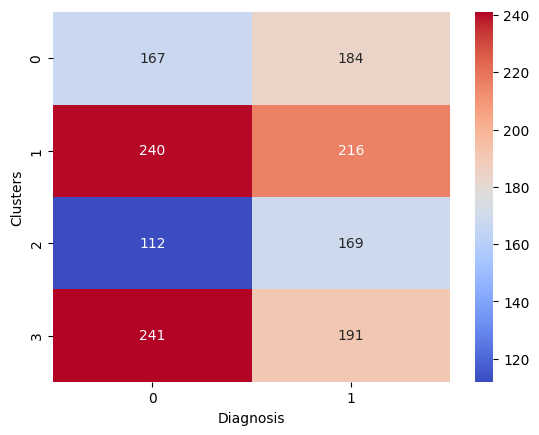

In [28]:
# Ignoro affinity propagation porque tiene muchos labels
contingency_table = pd.crosstab(clustering_instance.clusters['KMeans_4'], np.squeeze(y))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Diagnosis")
plt.ylabel("Clusters")
plt.savefig('img/clustering-contingency-kmeans4.png')

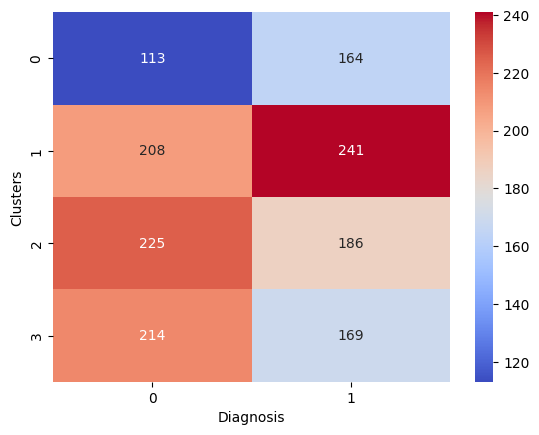

In [26]:
contingency_table = pd.crosstab(clustering_instance.clusters['SpectralClustering_4'], np.squeeze(y))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Diagnosis")
plt.ylabel("Clusters")
plt.show()

### Hiperparametros

In [3]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import make_scorer

In [5]:
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42)

param_grid = {
    'n_neighbors': [2, 3, 4, 5],  # Ensure n_neighbors is less than or equal to the number of samples
    'gamma': [0.1, 0.5, 1.0, 2.0],
    'affinity': ['nearest_neighbors', 'rbf']
}

def custom_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

halving_search = HalvingGridSearchCV(
    estimator=spectral_clustering,
    param_grid=param_grid,
    factor=2,
    resource='n_samples',
    max_resources=X.shape[0],
    scoring=custom_silhouette_scorer,
    cv=5,
    verbose=2
)

halving_search.fit(X)

print("Best parameters:", halving_search.best_params_)
print("Best score:", halving_search.best_score_)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 47
max_resources_: 1520
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 32
n_resources: 47
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=3; total time=   0.0s


/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Gr

[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=5; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=5; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.1, n_neighbors=5; total time=   0.0s
[CV] END affinit

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Gr

[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=0.5, n_neighbors=4; total time=   0.0s
[CV] END affinit

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Gr

[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=2; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=1.0, n_neighbors=5; total time=   0.0s
[CV] END affinit

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Gr

[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=3; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=4; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=5; total time=   0.0s
[CV] END affinity=nearest_neighbors, gamma=2.0, n_neighbors=5; total time=   0.0s
[CV] END affinit

KeyboardInterrupt: 

In [29]:
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

kmeans = KMeans(random_state=42, n_clusters=2)

param_grid = {
    'init': ['k-means++', 'random'], 
    'n_init': ['auto', 10, 20, 30],
    'max_iter': [100, 200, 300], 
    'algorithm': ["lloyd", "elkan"]
}

search = HalvingGridSearchCV(
    estimator=kmeans,
    param_grid=param_grid,
    factor=2,
    resource='n_samples',
    max_resources=X.shape[0], 
    scoring=silhouette_scorer,
    cv=5,
    verbose=2
)

# Ajustar el modelo
search.fit(X)
# Ver mejores parámetros
print("Mejores parámetros:", search.best_params_)
print("Mejor score:", search.best_score_)

NameError: name 'HalvingGridSearchCV' is not defined

Nota: Es el mismo codigo de arriba solo que con los hiperparametros considerados

Tiene el mismo bug, si debe ser reiniciado el Kernel y ejecutando las primeras 2 celdas de este notebook + de esta celda en adelante para que funcione

In [3]:
class Clustering():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.clusters = {}
        self.scores = {}
        self.models = {}
        # {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_init': 30}
        self.models['KMeans_2'] = KMeans(n_clusters=2, init='k-means++', n_init=30, max_iter=100, algorithm='lloyd', random_state=42)
        # {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 200, 'n_init': 30}
        self.models['KMeans_4'] = KMeans(n_clusters=4, init='k-means++', n_init=30, max_iter=200, algorithm='lloyd', random_state=42)
        # {'affinity': 'rbf', 'gamma': 0.1, 'n_neighbors': 5}
        self.models['SpectralClustering_4'] = SpectralClustering(n_clusters=4, affinity='rbf', gamma=0.1, n_neighbors=5, random_state=42)
    def apply_pca(self, n_components=2):
        pca = PCA(n_components=n_components)
        self.X_pca = pca.fit_transform(self.X)

        
    def fit(self):
        for name, model in self.models.items():
            print(f'Fitting {name}')
            model.fit(self.X)
            if hasattr(model, 'predict'):
                self.clusters[name] = model.predict(self.X)
                labels = model.labels_
            else:
                self.clusters[name] = model.labels_
                labels = model.labels_
            valid_mask = labels != -1
            X_valid = self.X[valid_mask]
            valid_labels = labels[valid_mask]

            self.scores[name] = {}
            if len(set(valid_labels)) > 1:
                label_counts = np.bincount(valid_labels)
                self.scores[name]['siluetas'] = silhouette_score(X=X_valid, labels=valid_labels)
                self.scores[name]['calinski'] = calinski_harabasz_score(X=X_valid, labels=valid_labels)
                self.scores[name]['davies'] = davies_bouldin_score(X=X_valid, labels=valid_labels)
                self.scores[name]['entropia'] = entropy(label_counts / len(valid_labels), base=2)
            else:
                self.scores[name]['siluetas'] = None
                self.scores[name]['calinski'] = None
                self.scores[name]['davies'] = None
                self.scores[name]['entropia'] = 0  # No hay entropía si solo hay un cluster
    
    def plot(self):
        for name, model in self.models.items():
            clusters = self.clusters[name]
            unique_clusters = np.unique(clusters)

            for cluster in unique_clusters:
                mask = clusters == cluster
                plt.scatter(self.X_pca[mask, 0], self.X_pca[mask, 1], 
                            label=f'Cluster {cluster}' if cluster != -1 else 'Noise',
                            alpha=0.7)
            plt.title(f'Clustering con {name}')
            plt.legend(title="Clusters")
            plt.show()
    
    def get_scores(self):
        data = []
        for name, model in self.models.items():
            noise = np.sum(self.clusters[name] == -1)
            data.append([name, self.scores[name]['siluetas'], self.scores[name]['calinski'], self.scores[name]['davies'], self.scores[name]['entropia'], noise])
        return pd.DataFrame(data, columns=['Modelo', 'Siluetas', 'Calinski', 'Davies', 'Entropia', 'Ruido'])
        
    def predict(self, X):
        for name, model in self.models.items():
            self.clusters[name] = model.predict(X)
        return self.clusters
    
    def statistics(self):
        self.statistics = {}
        for name, model in self.models.items():
            self.statistics[name] = {}
            print(f'Estadísticas para {name}')
            self.statistics[name]["n_clusters"] = len(set(model.labels_))
            self.statistics[name]["cluster_sizes"] = pd.Series(model.labels_).value_counts().to_frame().reset_index().rename(columns={'index': 'Cluster', 'count': 'Size'})
            data = pd.concat([self.X, pd.Series(model.labels_, name='Cluster')], axis=1)
            descriptive_stats = data.groupby('Cluster').describe()
            self.statistics[name]["descriptive_stats"] = descriptive_stats
            krskl = []
            clusters = self.statistics[name]["cluster_sizes"]["Cluster"].values
            for column in self.X.columns:
                groups = [data.loc[data["Cluster"] == cluster, column].values for cluster in clusters]
                krskl.append([column, *kruskal(*groups)])
                del groups
            self.statistics[name]["kruskal"] = pd.DataFrame(krskl, columns=["Column", "H", "p-value"])

In [4]:
kmeans = Clustering(X, y)
kmeans.fit()

Fitting KMeans_2
Fitting KMeans_4
Fitting SpectralClustering_4


In [5]:
kmeans.get_scores()

Modelo  Siluetas   Calinski    Davies  Entropia  Ruido
0              KMeans_2  0.044169  62.643850  4.839989  0.976431      0
1              KMeans_4  0.043849  47.349503  4.258601  1.988765      0
2  SpectralClustering_4  0.025571  37.398067  4.548636  1.998164      0

In [6]:
kmeans.statistics()

Estadísticas para KMeans_2
Estadísticas para KMeans_4
Estadísticas para SpectralClustering_4


In [7]:
clustersize_df = pd.DataFrame()
descriptive_stats_df = pd.DataFrame()
kruskal_df = pd.DataFrame()

for name in kmeans.models.keys():
    print(f"Algorithm: {name}\tN_clusters: {kmeans.statistics[name]["n_clusters"]}")
    
    clustersize = kmeans.statistics[name]["cluster_sizes"]
    clustersize["Model"] = name
    clustersize_df = pd.concat([clustersize_df, clustersize])

    descriptive_stats = kmeans.statistics[name]["descriptive_stats"]
    descriptive_stats["Model"] = name
    descriptive_stats_df = pd.concat([descriptive_stats_df, descriptive_stats])

    kruskal = kmeans.statistics[name]["kruskal"]
    kruskal["Model"] = name
    kruskal_df = pd.concat([kruskal_df, kruskal])

Algorithm: KMeans_2	N_clusters: 2
Algorithm: KMeans_4	N_clusters: 4
Algorithm: SpectralClustering_4	N_clusters: 4


In [8]:
clustersize_df

Cluster  Size                 Model
0        1   897              KMeans_2
1        0   623              KMeans_2
0        3   460              KMeans_4
1        1   366              KMeans_4
2        2   363              KMeans_4
3        0   331              KMeans_4
0        2   401  SpectralClustering_4
1        0   396  SpectralClustering_4
2        3   368  SpectralClustering_4
3        1   355  SpectralClustering_4

In [9]:
descriptive_stats_df

Age                                                                \
         count      mean       std     min     25%      50%      75%     max   
Cluster                                                                        
0        623.0 -0.001204  0.557080 -0.9375 -0.5000  0.00000  0.46875  0.9375   
1        897.0 -0.022506  0.565301 -0.9375 -0.5000 -0.06250  0.50000  0.9375   
0        331.0 -0.033044  0.550745 -0.9375 -0.5000 -0.06250  0.43750  0.9375   
1        366.0 -0.078723  0.552880 -0.9375 -0.5625 -0.12500  0.37500  0.9375   
2        363.0  0.025826  0.578222 -0.9375 -0.4375  0.00000  0.56250  0.9375   
3        460.0  0.020516  0.560214 -0.9375 -0.4375  0.06250  0.50000  0.9375   
0        396.0 -0.043403  0.562808 -0.9375 -0.5000 -0.09375  0.43750  0.9375   
1        355.0 -0.107042  0.539312 -0.9375 -0.5625 -0.18750  0.34375  0.9375   
2        401.0  0.060630  0.565803 -0.9375 -0.4375  0.06250  0.56250  0.9375   
3        368.0  0.027004  0.564929 -0.9375 -0.4375  0.06250  0.56250  0.9375   

        Gender            ... EducationLevel_2 EducationLevel_3            \
         count      mean  ...              max            count      mean   
Cluster                   ...                                               
0        623.0  0.495987  ...              1.0            623.0  0.102729   
1        897.0  0.499443  ...              1.0            897.0  0.092531   
0        331.0  0.480363  ...              1.0            331.0  0.108761   
1        366.0  0.505464  ...              1.0            366.0  0.000000   
2        363.0  0.487603  ...              0.0            363.0  0.305785   
3        460.0  0.513043  ...              0.0            460.0  0.000000   
0        396.0  0.484848  ...              1.0            396.0  0.108586   
1        355.0  0.535211  ...              1.0            355.0  0.126761   
2        401.0  0.503741  ...              1.0            401.0  0.089776   
3        368.0  0.470109  ...              1.0            368.0  0.062500   

                                                           Model  
              std  min  25%  50%  75%  max                        
Cluster                                                           
0        0.303848  0.0  0.0  0.0  0.0  1.0              KMeans_2  
1        0.289935  0.0  0.0  0.0  0.0  1.0              KMeans_2  
0        0.311811  0.0  0.0  0.0  0.0  1.0              KMeans_4  
1        0.000000  0.0  0.0  0.0  0.0  0.0              KMeans_4  
2        0.461375  0.0  0.0  0.0  1.0  1.0              KMeans_4  
3        0.000000  0.0  0.0  0.0  0.0  0.0              KMeans_4  
0        0.311512  0.0  0.0  0.0  0.0  1.0  SpectralClustering_4  
1        0.333174  0.0  0.0  0.0  0.0  1.0  SpectralClustering_4  
2        0.286217  0.0  0.0  0.0  0.0  1.0  SpectralClustering_4  
3        0.242391  0.0  0.0  0.0  0.0  1.0  SpectralClustering_4  

[10 rows x 305 columns]

In [10]:
kruskal_df[(kruskal_df["Model"] == "SpectralClustering_4") & (kruskal_df["p-value"] < 0.05)].sort_values(by=["H"], ascending=False)

Column           H       p-value                 Model
16          CholesterolTotal  439.867960  5.110592e-95  SpectralClustering_4
35          EducationLevel_1  393.279191  6.322652e-85  SpectralClustering_4
36          EducationLevel_2  323.186964  9.524606e-70  SpectralClustering_4
21      FunctionalAssessment  320.222802  4.173671e-69  SpectralClustering_4
2                        BMI  205.239542  3.111510e-44  SpectralClustering_4
4         AlcoholConsumption  204.123736  5.421168e-44  SpectralClustering_4
14                SystolicBP  189.521918  7.742513e-41  SpectralClustering_4
6                DietQuality  157.658308  5.867605e-34  SpectralClustering_4
24                       ADL  110.556388  8.329015e-24  SpectralClustering_4
30               Ethnicity_0  104.313860  1.835478e-22  SpectralClustering_4
19  CholesterolTriglycerides   82.035803  1.122778e-17  SpectralClustering_4
31               Ethnicity_1   77.061235  1.309946e-16  SpectralClustering_4
20                      MMSE   73.359143  8.142077e-16  SpectralClustering_4
18            CholesterolHDL   69.737663  4.857709e-15  SpectralClustering_4
7               SleepQuality   63.568121  1.015302e-13  SpectralClustering_4
17            CholesterolLDL   59.214709  8.649702e-13  SpectralClustering_4
13              Hypertension   30.864235  9.078784e-07  SpectralClustering_4
34          EducationLevel_0   26.582114  7.202847e-06  SpectralClustering_4
0                        Age   19.705461  1.953489e-04  SpectralClustering_4
5           PhysicalActivity   13.560056  3.569478e-03  SpectralClustering_4
32               Ethnicity_2   12.141019  6.915374e-03  SpectralClustering_4
3                    Smoking   11.081038  1.129565e-02  SpectralClustering_4
23        BehavioralProblems    9.920660  1.925273e-02  SpectralClustering_4
37          EducationLevel_3    9.453630  2.382981e-02  SpectralClustering_4

In [11]:
kmeans.apply_pca()

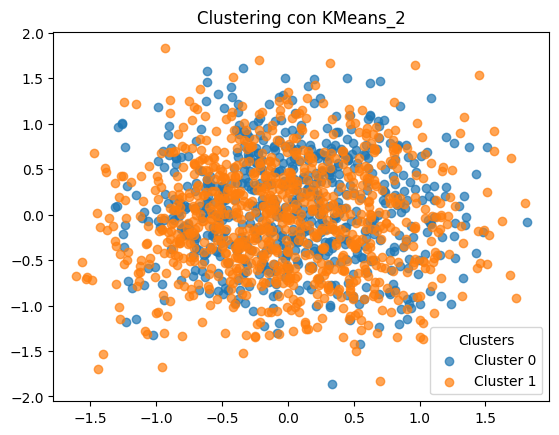

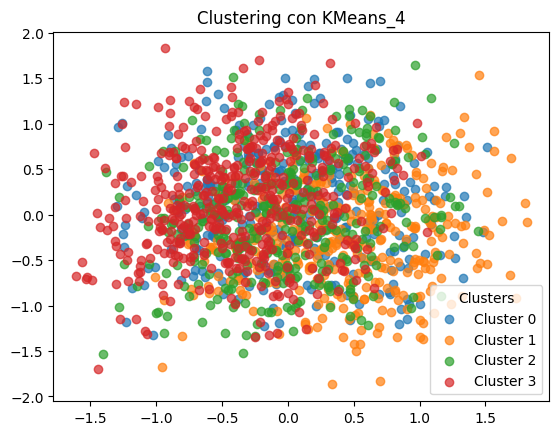

In [12]:
kmeans.plot()

In [13]:
pd.DataFrame(kmeans.models['KMeans_4'].labels_, columns=['Cluster']).to_csv("data/clustering/labels_kmeans4.csv", index=False)
pd.DataFrame(kmeans.models['KMeans_2'].labels_, columns=['Cluster']).to_csv("data/clustering/labels_kmeans2.csv", index=False)
pd.DataFrame(kmeans.models['SpectralClustering_4'].labels_, columns=['Cluster']).to_csv("data/clustering/labels_spectral4.csv", index=False)